# **Deep Learning -  Homework - I. Milestone**


---

Group Members: El-Ali Maya (BHI5LF), Simkó Máté (O3BMRX)

###**Chosen task: Friend recommendation with graph neural networks**
###**Dataset: [Facebook Dataset](https://snap.stanford.edu/data/ego-Facebook.html)**


# Imports

In [77]:
# install dgl
! pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
! pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
Looking in links: https://data.dgl.ai/wheels-test/repo.html


In [95]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import dgl

# Data

In [79]:
# download the dataset
! wget "https://snap.stanford.edu/data/facebook.tar.gz"
! wget "https://snap.stanford.edu/data/facebook_combined.txt.gz"

--2023-10-19 21:48:41--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz.1’

facebook.tar.gz.1   100%[===================>] 714.95K  3.25MB/s    in 0.2s    

2023-10-19 21:48:43 (3.25 MB/s) - ‘facebook.tar.gz.1’ saved [732104/732104]

--2023-10-19 21:48:43--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz.1’

facebook_combined.t 100%[===================>] 213.45K  --.-KB/s    in 0.1s    

2023-10-19 21:48:43 (2.18 MB/s) - ‘facebook_combined.txt.gz

In [80]:
# unpack the dataset
! mkdir "data"
! tar -xzf facebook.tar.gz -C /content/data
! gunzip -c facebook_combined.txt.gz > /content/data/facebook_combined.txt

mkdir: cannot create directory ‘data’: File exists


In [81]:
# get the ego users of the subgraphs
folder_path = "/content/data/facebook"
ego_users = []

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        # Split the filename and extension
        name, _ = os.path.splitext(filename)
        ego_users.append(int(name))

ego_users = list(set(ego_users))

print(ego_users)

[0, 107, 3980, 3437, 686, 1684, 1912, 698, 348, 414]


In [82]:
# helper structs
def get_index_dicts(node_labels):
  node_labels = sorted(node_labels)

  index_to_label = {}
  label_to_index = {}
  for idx, node_label in enumerate(node_labels):
      index_to_label[idx] = node_label
      label_to_index[node_label] = idx
  return index_to_label, label_to_index

In [83]:
# creates a DGL graph object for each subgraph
def get_dgl_graph(user_id, ego_users):
  if user_id not in ego_users:
    raise Exception("Subgraph not available for user {}".format(user_id))

  edge_data_file = "/content/data/facebook/{}.edges".format(user_id)
  feat_data_file = "/content/data/facebook/{}.feat".format(user_id)

  # feature data
  feats = []
  node_labels = []
  with open(feat_data_file) as f:  # load node features file
      for line in f:
          node_labels.append(int(line.split()[0]))
          a = [int(x) for x in line.split()[1:]]
          feats.append(torch.tensor(a, dtype=torch.float))
  feats = torch.stack(feats)

  # mapping node_labels to indeces
  idx_to_lab_dict, lab_to_idx_dict = get_index_dicts(node_labels)

  # edge data
  edges_u, edges_v = [], []
  with open(edge_data_file) as f:  # load edges file
      for line in f:
          edges_u.append(int(line.split()[0]))
          edges_v.append(int(line.split()[1]))

  # transform node_labels to indeces
  edges_u = [lab_to_idx_dict[x] for x in edges_u]
  edges_v = [lab_to_idx_dict[x] for x in edges_v]
  edges_u, edges_v = np.array(edges_u), np.array(edges_v)

  # Construct graph
  G = dgl.DGLGraph()
  G.add_nodes(len(node_labels))
  G.add_edges(edges_u, edges_v)
  G.ndata['feat'] = feats
  G.ndata['ego_user'] = torch.full((G.ndata['feat'].shape[0],1), user_id)
  G.ndata['node_label'] = torch.tensor(list(idx_to_lab_dict.values()), dtype=torch.int)

  return G

# Data Exploration

## Utility functions

In [84]:
#defining a function for dataset visualisation
def visualize(labels, g, node_size=100, pos = None, file_name = None, title = ""):
    if (pos == None):
      pos = nx.spring_layout(g, seed=1)

    figsize=(16,16)
    line_style='dotted'

    plt.figure(figsize=figsize)
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=node_size, cmap=plt.get_cmap('coolwarm'), node_color = labels,
                     edge_color='k', style=line_style, arrows=False, width=0.5, with_labels=False)
    plt.title(title)
    plt.show()

    if (file_name != None):
      plt.savefig(file_name)

## Ego Subgraphs

In [85]:
# read in the ego subgraphs
ego_graphs = []
for user_id in ego_users:
  g = get_dgl_graph(user_id, ego_users)
  ego_graphs.append(g)
ego_graphs

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


[Graph(num_nodes=347, num_edges=5038,
       ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=1045, num_edges=53498,
       ndata_schemes={'feat': Scheme(shape=(576,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=59, num_edges=292,
       ndata_schemes={'feat': Scheme(shape=(42,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=547, num_edges=9626,
       ndata_schemes={'feat': Scheme(shape=(262,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=170, num_edges=3312,
       

## Complete graph

In [86]:
# Read the graph
# edge data
edges_u, edges_v = [], []
with open("/content/data/facebook_combined.txt") as f:  # load edges file
    for line in f:
        edges_u.append(int(line.split()[0]))
        edges_v.append(int(line.split()[1]))
G = dgl.graph((edges_u,edges_v))
# for visualisation
nxG = G.to_networkx()
G

Graph(num_nodes=4039, num_edges=88234,
      ndata_schemes={}
      edata_schemes={})

In [87]:
# Basic attributes of the graph
print('%d nodes.' % G.number_of_nodes())
print('%d edges.' % G.number_of_edges())

4039 nodes.
88234 edges.


In [89]:
# Add community data - which ego subgraph the node belongs to
node_labels = np.zeros(G.number_of_nodes())
for label, g in zip(ego_users, ego_graphs):
  nodes = g.nodes().detach().numpy()
  for node in nodes:
    node_labels[node] = label

# Create a color map
cmap = plt.get_cmap('coolwarm')

# Normalize values to 0-1
norm = plt.Normalize(min(node_labels), max(node_labels))

# Apply the color map
colors = cmap(norm(node_labels))

colors = torch.tensor(colors)
colors

tensor([[0.5054, 0.6440, 0.9832, 1.0000],
        [0.5054, 0.6440, 0.9832, 1.0000],
        [0.5054, 0.6440, 0.9832, 1.0000],
        ...,
        [0.2298, 0.2987, 0.7537, 1.0000],
        [0.2298, 0.2987, 0.7537, 1.0000],
        [0.2298, 0.2987, 0.7537, 1.0000]], dtype=torch.float64)

In [90]:
# precalculate the layout for visualisation
pos = nx.spring_layout(nxG, seed=1)

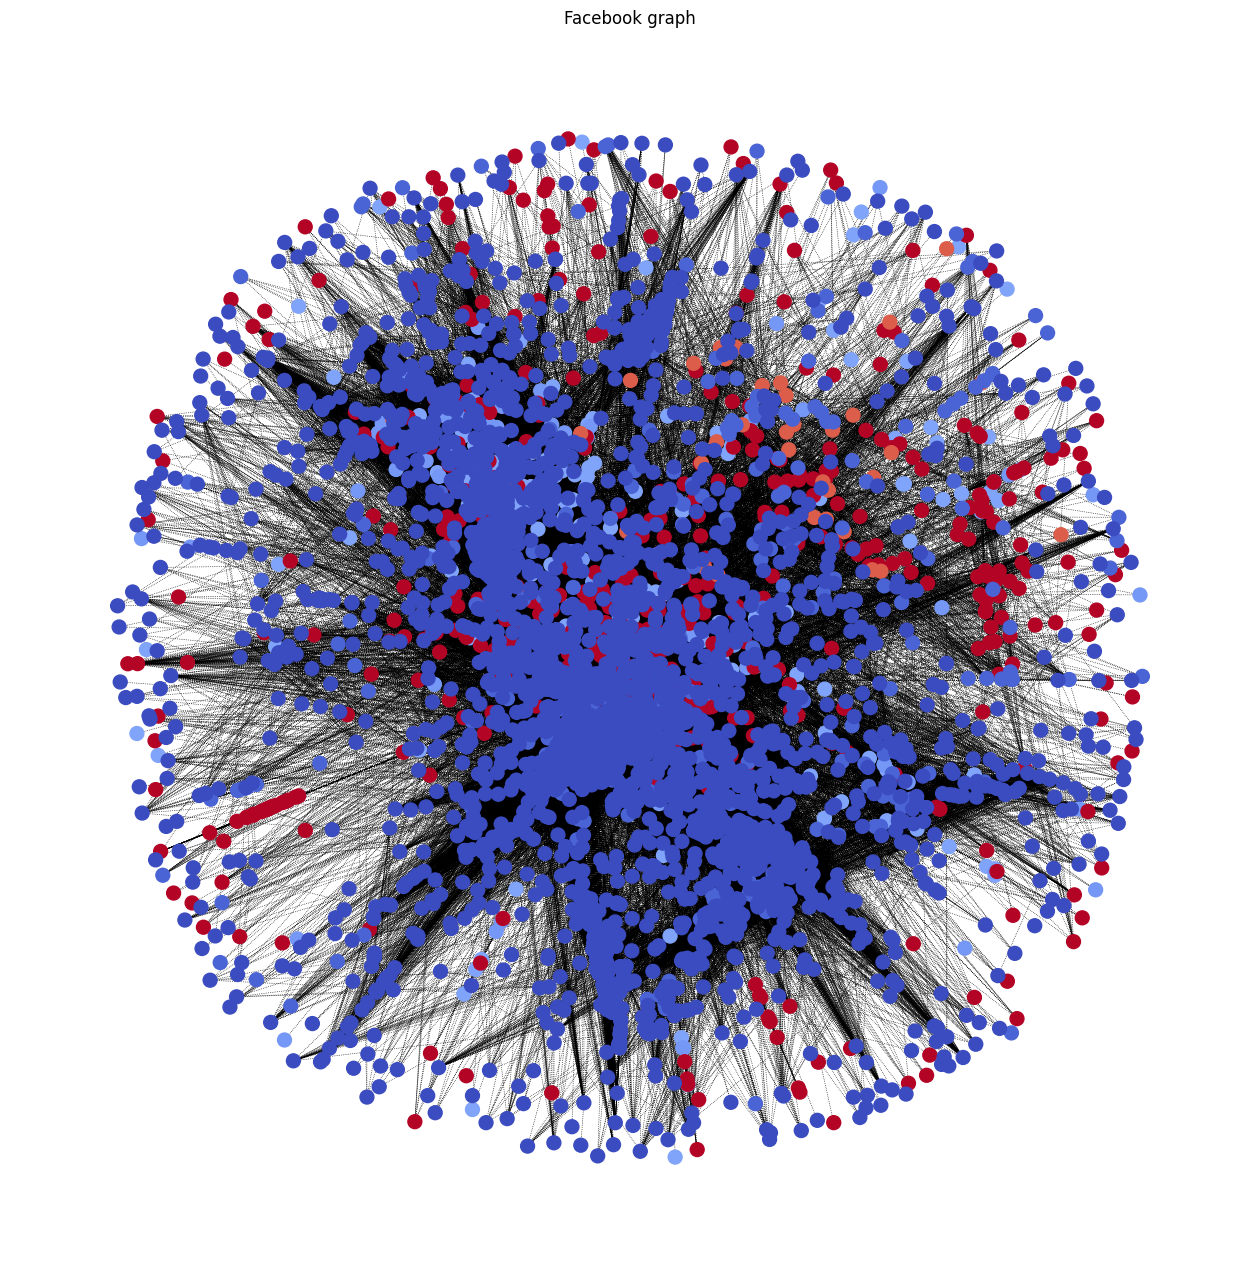

In [91]:
# visualise the graph
#converting to networkx for visualisation
visualize(node_labels, nxG, pos = pos, title = "Facebook graph")

# Data Preparation

We create an inverse of the graphs: G(V,E) is the original graph, invG(V, invE) is the inverse graph. Both graphs have the same nodes and in invG there is a edge between two nodes precisely when there isn't one in G.

This will be used to evaluate whether the model correctly predicts the missing edges as well.

In [113]:
def inverse_edges(G):
  u, v = G.edges()

  # Find all negative edges
  adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
  adj_neg = 1 - adj.todense() - np.eye(G.number_of_nodes())  # substract the og adjacency matrix and the self loops
  neg_u, neg_v = np.where(adj_neg != 0)

  return neg_u, neg_v

Usually for a friend recommendation system for the train/test split we split the data in time: the train set would be the edges at a given time, and the test set would be the edges at a later time. However this is not available for this dataset, so we split the edges randomly into 3 sets: training, validation and test

In [115]:
def split_graph(g, TEST_RATIO = 0.2, VAL_RATIO = 0.1):
  u, v = g.edges()

  eids = np.arange(g.number_of_edges())
  eids = np.random.permutation(eids)
  test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set
  val_size = int(len(eids) * VAL_RATIO)   # number of edges in val set
  train_size = g.number_of_edges() - test_size - val_size # number of edges in train set

  # get positive edges for test and train
  test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
  val_pos_u, val_pos_v = u[eids[test_size:test_size + val_size]], v[eids[test_size:test_size + val_size]]
  train_pos_u, train_pos_v = u[eids[test_size + val_size:]], v[eids[test_size + val_size:]]

  # Find all negative edges
  neg_u, neg_v = inverse_edges(g)

  # split the negative edges
  neg_eids =  np.random.choice(len(neg_u), g.number_of_edges())
  test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
  val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size + val_size]], neg_v[neg_eids[test_size:test_size + val_size]]
  train_neg_u, train_neg_v = neg_u[neg_eids[test_size + val_size:]], neg_v[neg_eids[test_size + val_size:]]

  # construct positive and negative graphs
  train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
  train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

  val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes())
  val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes())

  test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
  test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

  # training graph
  train_g = dgl.remove_edges(g, eids[:test_size + val_size])
  train_g = dgl.add_self_loop(train_g)

  return {
      'graph': train_g,
      'train_graph': (train_pos_g, train_neg_g),
      'val_graph': (val_pos_g, val_neg_g),
      'test_graph': (test_pos_g, test_neg_g)
      }

In [117]:
split_ego_graphs = []
for g in ego_graphs:
  split_ego_graphs.append(split_graph(g))

In [118]:
split_ego_graphs

[{'graph': Graph(num_nodes=347, num_edges=3875,
        ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
        edata_schemes={}),
  'train_graph': (Graph(num_nodes=347, num_edges=3528,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=3528,
         ndata_schemes={}
         edata_schemes={})),
  'val_graph': (Graph(num_nodes=347, num_edges=503,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=503,
         ndata_schemes={}
         edata_schemes={})),
  'test_graph': (Graph(num_nodes=347, num_edges=1007,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=1007,
         ndata_schemes={}
         edata_schemes={}))},
 {'graph': Graph(num_nodes=1045, num_edges=38495,
        ndata_schemes={'feat': Scheme(shape=(576,), dtype=torch.float32), 'ego_user': Schem